In [4]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import geopandas as gpd
import glob
import pycountry
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

In [2]:
import pandas as pd
import polars as pl
import pyasn
import numpy as np
from tqdm.notebook import tqdm
from functools import lru_cache
import glob
import ipaddress
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

sys.path.append('/home/service/ipinfos')
import get_ip_infos as gip

In [2]:
def load_and_join(files):
    df = pl.DataFrame()
    for i in tqdm(range(len(files))):
        if df.is_empty():
            df = pl.read_parquet(files[i],columns=['saddr','classification'])
            df = df.group_by("saddr").agg(classifications = pl.col("classification").unique())
            df = df.with_columns(
                pl.when((pl.col("classifications").list.contains("echoreply")) & 
                        (pl.col("classifications").list.len() == 1))
                .then(pl.lit("echoreply"))
                .when((pl.col("classifications").list.contains("echoreply")) & 
                      (pl.col("classifications").list.len() > 1))
                .then(pl.lit("ambiguous"))
                .otherwise(pl.lit("other"))
                .alias("code")
            ).drop('classifications')
            df = df.with_columns(inscan=True)
        else:
            tmp = pl.read_parquet(files[i],columns=['saddr','classification'])
            tmp = tmp.group_by("saddr").agg(classifications = pl.col("classification").unique())
            tmp = tmp.with_columns(
                pl.when((pl.col("classifications").list.contains("echoreply")) & 
                        (pl.col("classifications").list.len() == 1))
                .then(pl.lit("echoreply"))
                .when((pl.col("classifications").list.contains("echoreply")) & 
                      (pl.col("classifications").list.len() > 1))
                .then(pl.lit("ambiguous"))
                .otherwise(pl.lit("other"))
                .alias("code")
            ).drop('classifications')
            tmp = tmp.with_columns(inscan=True)
            df = df.join(tmp,on=['saddr'],how='full', suffix=f'_s{i}',coalesce=True)
            
    return df

In [5]:
tum_sra_files = glob.glob(f'{DATA_DIR}/*sra*_p0')
tum_rand_files = glob.glob(f'{DATA_DIR}/*rand*_p0')

In [8]:
tum_rand_files

['/home/service/artifacts-ipv6-sra-scanning/data/zmap_icmp_tum_64_rand_1731697959_p0',
 '/home/service/artifacts-ipv6-sra-scanning/data/zmap_icmp_tum_64_rand_1731704447_p0',
 '/home/service/artifacts-ipv6-sra-scanning/data/zmap_icmp_tum_64_rand_1731713777_p0',
 '/home/service/artifacts-ipv6-sra-scanning/data/zmap_icmp_tum_64_rand_1731758491_p0',
 '/home/service/artifacts-ipv6-sra-scanning/data/zmap_icmp_tum_64_rand_1731768180_p0',
 '/home/service/artifacts-ipv6-sra-scanning/data/zmap_icmp_tum_64_rand_1731771420_p0']

In [9]:
tum_sra_df = load_and_join(tum_sra_files)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [13:35<00:00, 135.89s/it]


In [10]:
tum_rand_df = load_and_join(tum_rand_files)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [11:06<00:00, 111.03s/it]


In [11]:
total_rand = []
total_sra = []
echo_replies_rand = []
echo_replies_sra = []

for c1 in ['','_s1','_s2','_s3','_s4','_s5']:
    total_sra.append(len(tum_sra_df.filter(
                pl.col(f'inscan{c1}')
            ))
                     )
    echo_replies_sra.append(len(tum_sra_df.filter(
                (pl.col(f'inscan{c1}')) & (pl.col(f'code{c1}')=='echoreply')
            ))
                    )
    total_rand.append(len(tum_rand_df.filter(
                pl.col(f'inscan{c1}')
            ))
                     )
    echo_replies_rand.append(len(tum_rand_df.filter(
                (pl.col(f'inscan{c1}')) & (pl.col(f'code{c1}')=='echoreply')
            ))
                            )

In [12]:
data = {'Random':total_rand,
        'SRA Address':total_sra,
        'Echo replies Random':echo_replies_rand,
        'Echo replies SRA':echo_replies_sra
       }

In [13]:
data_df = pd.DataFrame(data)

In [14]:
data_df.to_pickle(f'{INTERIM_DATA_DIR}/tum_result_plot_data')

In [15]:
data_df = pd.read_pickle(f'{INTERIM_DATA_DIR}/tum_result_plot_data')

In [16]:
colors = ["#375E97", "#FB6542", "#c1195c", "#37975e"]
linestyles = ['--','solid','-.',':']

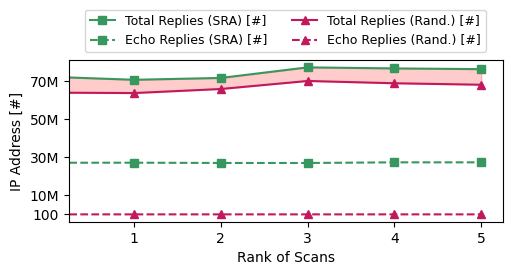

In [17]:
fig,ax = plt.subplots(figsize=(8*0.7,3*0.7))

ax.plot(data_df['SRA Address'],c=colors[3],label='Total Replies (SRA) [#]',linestyle=linestyles[1],marker='s')
ax.plot(data_df['Echo replies SRA'],label='Echo Replies (SRA) [#]',c=colors[3],linestyle=linestyles[0],marker='s')
ax.plot(data_df['Random'],c=colors[2],label='Total Replies (Rand.) [#]',linestyle=linestyles[1],marker='^')
ax.plot(data_df['Echo replies Random'],label='Echo Replies (Rand.) [#]',c=colors[2],linestyle=linestyles[0],marker='^')

ax.set_yticks([100,10**7,3*10**7,5*10**7,7*10**7])
ax.set_yticklabels(['100','10M','30M','50M','70M'])
ax.set_xlim(0.25,5.25)
ax.set_xlabel('Rank of Scans')
ax.set_ylabel('IP Address [#]')
handles,labels=ax.get_legend_handles_labels()
ax.legend(ncols=2,fontsize=9,loc='upper right',bbox_to_anchor=(0.975,1.35))
ax.fill_between(
    data_df.index, data_df['Random'], data_df['SRA Address'], 
    interpolate=True, color="red", alpha=0.2
)


In [18]:
plt.rc("font", size=12)

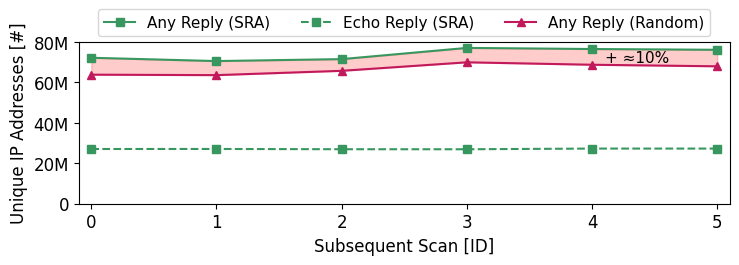

In [20]:
fig,ax = plt.subplots(figsize=(12*0.7,3*0.7))

ax.plot(data_df['SRA Address'],c=colors[3],label='Any Reply (SRA)',linestyle=linestyles[1],marker='s')
ax.plot(data_df['Echo replies SRA'],label='Echo Reply (SRA)',c=colors[3],linestyle=linestyles[0],marker='s')
ax.plot(data_df['Random'],c=colors[2],label='Any Reply (Random)',linestyle=linestyles[1],marker='^')
#ax.plot(data_df['Echo replies Random'],label='Echo Replies (Rand.) [#]',c=colors[2],linestyle=linestyles[0],marker='^')

ax.set_yticks([0,2*10**7,4*10**7,6*10**7,8*10**7])
ax.set_yticklabels([0,'20M','40M','60M','80M'])
ax.set_ylim(0*10**7, 8*10**7)
ax.set_xlim(-0.1,5.1)
ax.set_xlabel('Subsequent Scan [ID]')
ax.set_ylabel('Unique IP Addresses [#]')
handles,labels=ax.get_legend_handles_labels()
ax.legend(ncols=3,fontsize=11,loc='upper center',bbox_to_anchor=(0.5,1.25))
ax.fill_between(
    data_df.index, data_df['Random'], data_df['SRA Address'], 
    interpolate=True, color="red", alpha=0.2
)
ax.text(4.1,7*10**7,'+ ≈10%',fontsize=11)

plt.savefig(f'../reports/figures/tum64_sra_vs_rand.png',dpi=300, bbox_inches='tight')
plt.savefig(f'../reports/figures/tum64_sra_vs_rand.pdf', bbox_inches='tight')
plt.show()
plt.close()